<a href="https://colab.research.google.com/github/Royal1shrestha/Google_Collab/blob/main/Reccomender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import pickle

In [ ]:
df_rating = pd.read_csv('/content/sample_data/Books/BX-Book-Ratings.csv', sep=";", error_bad_lines=False, encoding='latin1')
df_books = pd.read_csv('/content/sample_data/Books/BX-Books.csv', sep=";", error_bad_lines=False, encoding='latin1')
df_users = pd.read_csv('/content/sample_data/Books/BX-Users.csv', sep=";", error_bad_lines=False, encoding='latin1')
df_data = pd.read_csv('/content/sample_data/Books/BX-Data.csv', sep=",", error_bad_lines=False, encoding='latin1')

In [ ]:
df_rating.head(2)
# df_books.head(2)
# df_users.head(2)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


In [ ]:
df_images = df_books.iloc[:, -2:]
df_books = df_books.iloc[:, :-2]
df_books.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...


In [ ]:
df_data = df_data.iloc[:, :-1]
df_data.head()

,index,title,genre
0,0,Drowned Wednesday,fantasy
1,1,The Lost Hero,fantasy
2,2,The Eyes of the Overworld,fantasy
3,3,Magic's Promise,fantasy
4,4,Taran Wanderer,fantasy


In [ ]:
df_data = df_data[['title','genre']]
df_data.rename(columns={"title":"Book-Title","genre":"Book-Genre"}, inplace=True)
df_data.head()

<ipython-input-70-46093e471e4a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.rename(columns={"title":"Book-Title","genre":"Book-Genre"}, inplace=True)


,Book-Title,Book-Genre
0,Drowned Wednesday,fantasy
1,The Lost Hero,fantasy
2,The Eyes of the Overworld,fantasy
3,Magic's Promise,fantasy
4,Taran Wanderer,fantasy


In [ ]:
df_data.drop_duplicates(['Book-Title'], inplace=True)
df_data.head()

,Book-Title,Book-Genre
0,Drowned Wednesday,fantasy
1,The Lost Hero,fantasy
2,The Eyes of the Overworld,fantasy
3,Magic's Promise,fantasy
4,Taran Wanderer,fantasy


In [ ]:
userCounts = df_rating['User-ID'].value_counts()
print(userCounts)

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: User-ID, Length: 105283, dtype: int64


In [ ]:
df_books.isnull().sum()
# df_rating.isnull().sum()
# df_users.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
dtype: int64

In [ ]:
df_books['Book-Author'].fillna(df_books['Book-Author'].mode()[0], inplace=True)
df_books['Publisher'].fillna(df_books['Publisher'].mode()[0], inplace=True)

In [ ]:
dfr = df_rating
x = userCounts > 200
y = x[x].index
dfr = dfr[dfr['User-ID'].isin(y)]
dfr.head()

,User-ID,ISBN,Book-Rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0


In [ ]:
ratings_with_books = dfr.merge(df_books, on="ISBN")
ratings_with_books.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...


In [ ]:
num_ratings = (ratings_with_books.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().rename(columns={'Book-Rating': 'totalRatingCount'})[['Book-Title', 'totalRatingCount']])
num_ratings.head(3)

,Book-Title,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1


In [ ]:
num_users = (ratings_with_books[ratings_with_books['Book-Rating'] > 0].groupby('Book-Title')['User-ID'].nunique().reset_index().rename(columns={'User-ID': 'numUsers'})[['Book-Title', 'numUsers']])
num_users.head(4)

,Book-Title,numUsers
0,A Light in the Storm: The Civil War Diary of ...,1
1,Dark Justice,1
2,Earth Prayers From around the World: 365 Pray...,3
3,Final Fantasy Anthology: Official Strategy Gu...,1


In [ ]:
final_ratings = ratings_with_books.merge(num_ratings,on="Book-Title")
final_ratings.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82


In [ ]:
ratings_for_top_recommend = final_ratings.merge(num_users,on="Book-Title")
ratings_for_top_recommend.head(3)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,totalRatingCount,numUsers
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82,22
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82,22
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82,22


In [ ]:
final_ratings = final_ratings[final_ratings['totalRatingCount']>=50]
ratings_for_top_recommend = ratings_for_top_recommend[ratings_for_top_recommend['totalRatingCount']>=50]
final_ratings.head(3)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82


In [ ]:
final_ratings.drop_duplicates(['Book-Title','User-ID'], inplace=True)
ratings_for_top_recommend.drop_duplicates(['Book-Title'], inplace=True)

In [ ]:
final_ratings.head(3)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82


In [ ]:
ratings_for_top_recommend_filter = ratings_for_top_recommend[ratings_for_top_recommend['numUsers']>=10]
ratings_for_top_recommend_filter.loc[:, 'Avg-Rating'] = ratings_for_top_recommend_filter['totalRatingCount'] / ratings_for_top_recommend_filter['numUsers']
ratings_for_top_recommend_filtered = ratings_for_top_recommend_filter.sort_values(by="Avg-Rating", ascending=False)
final_ratings_for_top_recommend = ratings_for_top_recommend_filtered.merge(df_data,on="Book-Title")
final_ratings_for_top_recommend.head(5)

<ipython-input-61-752712adbfe4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_for_top_recommend_filter.loc[:, 'Avg-Rating'] = ratings_for_top_recommend_filter['totalRatingCount'] / ratings_for_top_recommend_filter['numUsers']


,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,totalRatingCount,numUsers,Avg-Rating,Book-Genre
0,277639,0440218535,0,Smilla's Sense of Snow,Peter Hoeg,1997,Island,http://images.amazon.com/images/P/0440218535.0...,http://images.amazon.com/images/P/0440218535.0...,http://images.amazon.com/images/P/0440218535.0...,82,10,8.200000,crime
1,278418,0425120279,0,The Hunt for Red October,Tom Clancy,1990,Berkley Publishing Group,http://images.amazon.com/images/P/0425120279.0...,http://images.amazon.com/images/P/0425120279.0...,http://images.amazon.com/images/P/0425120279.0...,101,14,7.214286,thriller
2,8245,0446606324,9,The Winner,David Baldacci,1998,Warner Vision,http://images.amazon.com/images/P/0446606324.0...,http://images.amazon.com/images/P/0446606324.0...,http://images.amazon.com/images/P/0446606324.0...,80,12,6.666667,thriller
3,277427,0446608890,10,Saving Faith,David Baldacci,2000,Warner Vision,http://images.amazon.com/images/P/0446608890.0...,http://images.amazon.com/images/P/0446608890.0...,http://images.amazon.com/images/P/0446608890.0...,86,13,6.615385,thriller
4,2276,0553582526,9,Dust to Dust,TAMI HOAG,2002,Bantam,http://images.amazon.com/images/P/0553582526.0...,http://images.amazon.com/images/P/0553582526.0...,http://images.amazon.com/images/P/0553582526.0...,78,12,6.500000,thriller


In [ ]:
authors = final_ratings_for_top_recommend['Book-Author'].value_counts().head(10)
authors

Stephen King                 25
Dean R. Koontz                9
John Grisham                  7
Patricia Daniels Cornwell     5
James Patterson               5
DEAN KOONTZ                   5
JOHN GRISHAM                  4
Tom Clancy                    3
Michael Crichton              3
Robin Cook                    3
Name: Book-Author, dtype: int64

<ipython-input-57-2590eb6b7a34>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y = "Book-Author", data = final_ratings_for_top_recommend, order = authors.index, palette = "Set3")


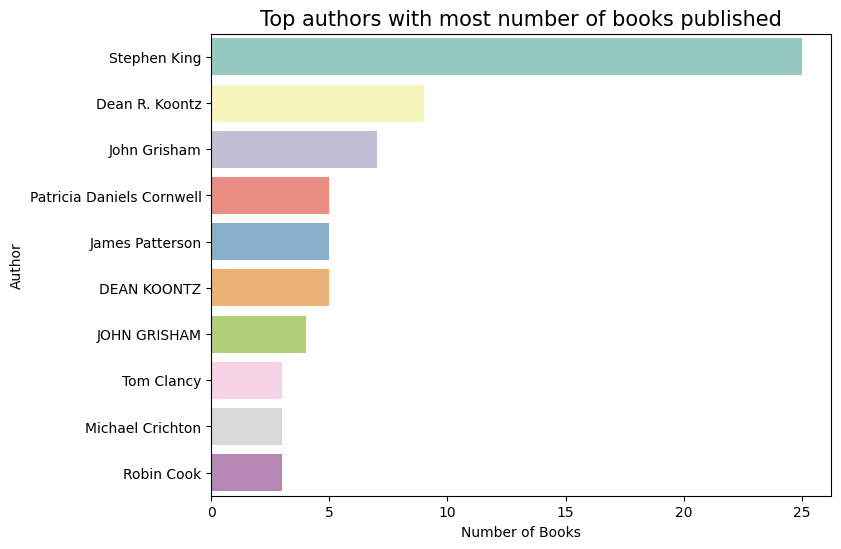

In [ ]:
# The top 10 authors with most number of books published:

plt.figure(figsize=(8,6))
sns.countplot(y = "Book-Author", data = final_ratings_for_top_recommend, order = authors.index, palette = "Set3")
plt.title('Top authors with most number of books published', fontsize = 15)
plt.xlabel('Number of Books')
plt.ylabel('Author')
plt.show()

<ipython-input-136-06c8e4a76faa>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=books['totalRatingCount'], y=books.index, palette='Set3')


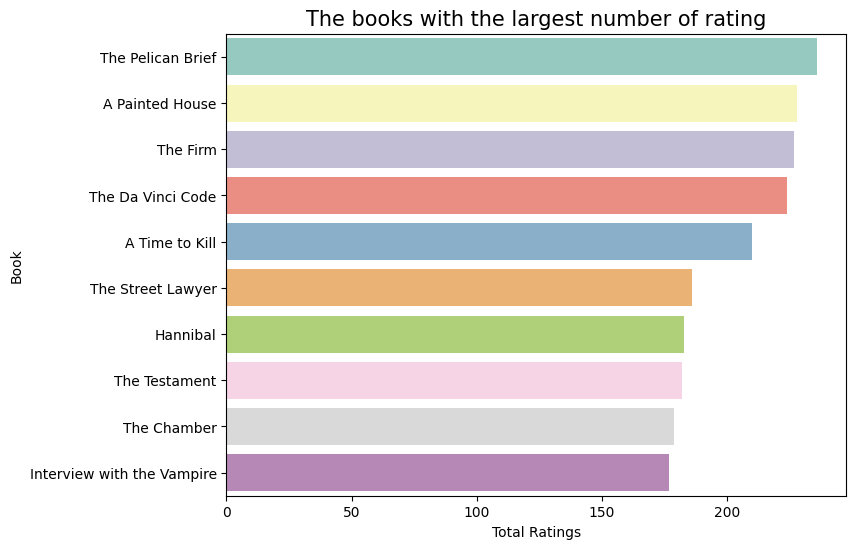

In [ ]:
# The most reviewed books

books = final_ratings_for_top_recommend.sort_values('totalRatingCount', ascending = False).head(10).set_index('Book-Title')
plt.figure(figsize=(8,6))
sns.barplot(x=books['totalRatingCount'], y=books.index, palette='Set3')
plt.title('The books with the largest number of rating', fontsize = 15)
plt.xlabel('Total Ratings')
plt.ylabel('Book')
plt.show()

<ipython-input-60-007f0120b12d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=books['Avg-Rating'], y=books.index, palette='Set3')


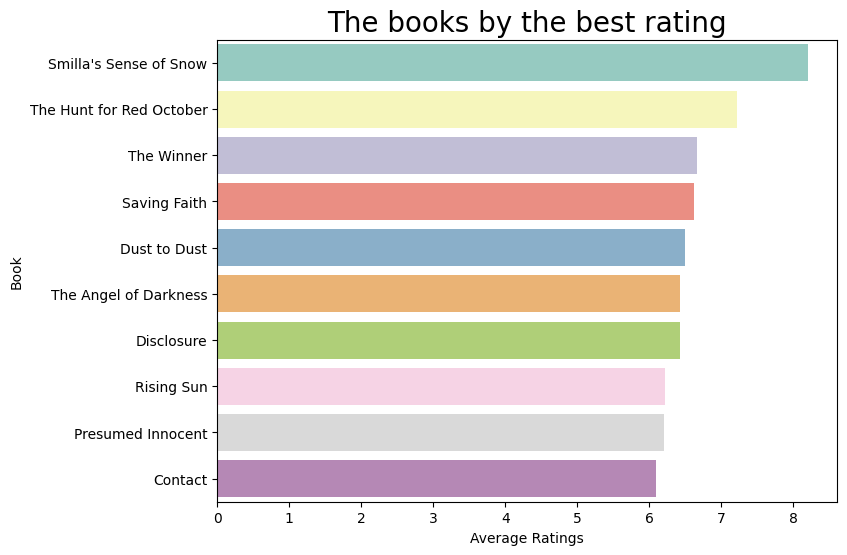

In [ ]:
# Top books by average rating

books = final_ratings_for_top_recommend.sort_values('Avg-Rating', ascending = False).head(10).set_index('Book-Title')
plt.figure(figsize=(8,6))
sns.barplot(x=books['Avg-Rating'], y=books.index, palette='Set3')
plt.title('The books by the best rating', fontsize = 20)
plt.xlabel('Average Ratings')
plt.ylabel('Book')
plt.show()

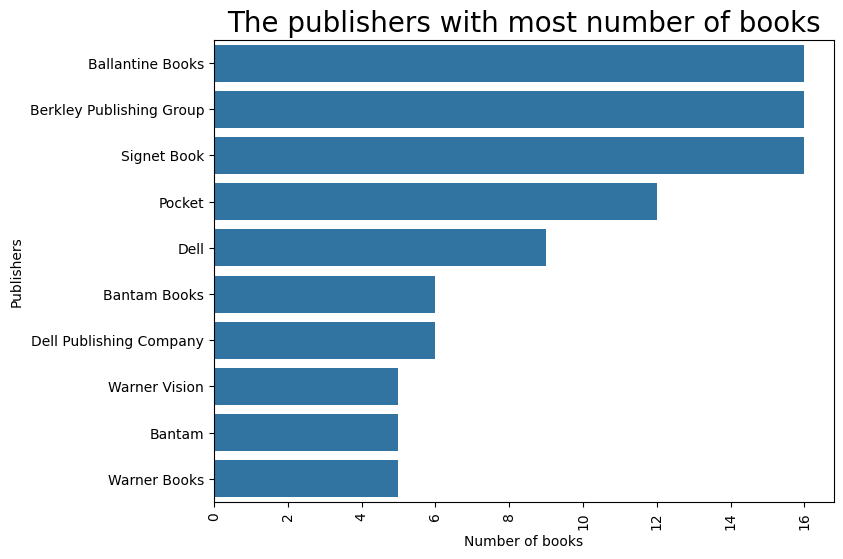

In [ ]:
# The publishing house with most number of books published

publisher = final_ratings_for_top_recommend['Publisher'].value_counts().head(10)
plt.figure(figsize=(8,6))
sns.barplot(x=publisher,y=publisher.index)
plt.xticks(rotation=90)
plt.title('The publishers with most number of books', fontsize = 20)
plt.ylabel('Publishers')
plt.xlabel('Number of books')
plt.show()

In [ ]:
final_ratings.shape

(59850, 9)

In [ ]:
book_pivot = final_ratings.pivot_table(columns='User-ID', index='Book-Title', values='Book-Rating')
book_pivot

User-ID,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84 Charing Cross Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [ ]:
book_pivot.shape

(742, 888)

In [ ]:
book_pivot.fillna(0,inplace=True)
book_pivot

User-ID,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Above matrix is a sparse matrix
# CSR matrix
book_sparse = csr_matrix(book_pivot)

In [ ]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(book_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
random_index = np.random.choice(book_sparse.shape[0])
distance, suggestion = model_knn.kneighbors(book_pivot.iloc[random_index,:].values.reshape(1,-1), n_neighbors=5)

In [ ]:
distance

array([[0.        , 0.46475172, 0.51854218, 0.57174192, 0.61377115]])

In [ ]:
suggestion

array([[524, 185, 386, 734, 149]])

In [ ]:
book_pivot.index

Index(['1984', '1st to Die: A Novel', '2nd Chance', '4 Blondes',
       '84 Charing Cross Road', 'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       'A Civil Action', 'A Cry In The Night',
       ...
       'Winter Solstice', 'Wish You Well', 'Without Remorse',
       'Wizard and Glass (The Dark Tower, Book 4)', 'Wuthering Heights',
       'Year of Wonders', 'You Belong To Me',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
       'Zoya', '\O\" Is for Outlaw"'],
      dtype='object', name='Book-Title', length=742)

In [ ]:
book_name = book_pivot.index

In [ ]:
for i in range(len(suggestion)):
  print(book_pivot.index[suggestion[i]])

Index(['Faking It', 'Fast Women', 'The Mulberry Tree', 'The Woman Next Door',
       'Midnight Bayou'],
      dtype='object', name='Book-Title')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pickle.dump(model_knn, open('drive/MyDrive/Model/model_knn.pkl','wb'))
pickle.dump(book_name, open('drive/MyDrive/Model/book_name.pkl','wb'))
pickle.dump(final_ratings, open('drive/MyDrive/Model/final_ratings.pkl','wb'))
pickle.dump(final_ratings_for_top_recommend, open('drive/MyDrive/Model/final_ratings_for_top_recommend.pkl','wb'))
pickle.dump(book_pivot, open('drive/MyDrive/Model/book_pivot.pkl','wb'))

In [ ]:
def get_recommend(book_name):
    try:
        book_id = np.where(book_pivot.index == book_name)[0][0]
    except IndexError:
        print("Book not found in the database.")
        return

    distance, suggestion = model_knn.kneighbors(book_pivot.iloc[book_id, :].values.reshape(1, -1), n_neighbors=5)

    recommended_books = []
    for i in range(len(suggestion)):
        books = book_pivot.index[suggestion[i]]
        for j in books:
          recommended_books.append(j)
    return recommended_books

In [ ]:
get_recommend("A Time to Kill")

['A Time to Kill',
 'The Pelican Brief',
 'The Client',
 'The Firm',
 'The Chamber']

In [ ]:
def get_recommend_test(book_name, k):
    try:
        book_id = np.where(book_pivot.index == book_name)[0][0]
    except IndexError:
        print("Book not found in the database.")
        return

    distance, suggestion = model_knn.kneighbors(book_pivot.iloc[book_id, :].values.reshape(1, -1), n_neighbors=k)

    recommended_books = []
    for i in range(len(suggestion)):
        books = book_pivot.index[suggestion[i]]
        for j in books:
          recommended_books.append(j)
    return recommended_books

In [ ]:
get_recommend_test("A Time to Kill",7)

['A Time to Kill',
 'The Pelican Brief',
 'The Client',
 'The Firm',
 'The Chamber',
 'The Rainmaker',
 'The Street Lawyer']

In [ ]:
book_pivot = pickle.load(open('/content/drive/MyDrive/Model/book_pivot.pkl','rb'))
book_name = pickle.load(open('/content/drive/MyDrive/Model/book_name.pkl','rb'))
final_ratings = pickle.load(open('/content/drive/MyDrive/Model/final_ratings.pkl','rb'))
final_ratings_for_top_recommend = pickle.load(open('/content/drive/MyDrive/Model/final_ratings_for_top_recommend.pkl','rb'))
model_knn = pickle.load(open('/content/drive/MyDrive/Model/book_pivot.pkl','rb'))

In [ ]:
def calculate_metrics( df_model_recommend, df_google_recommend):
    true_positives = 0
    false_positives = 0
    total_relevant = 0

    for i in range(len(df_model_recommend)):
        books = df_model_recommend[i]
        if books in df_google_recommend:
            total_relevant += 1
        else:
            false_positives += 1

    for i in range(len(df_model_recommend)):
        if df_model_recommend[i] == df_google_recommend[i]:
            true_positives += 1

    # Calculate precision, recall, and F1-score
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / total_relevant if (total_relevant) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

def set_zero():
  return 0, 0, 0, 0, 0, 0, 0, 0, 0

def initialize_lists():
    return [], [], [], [], [], [], [], [], []

def calculate_average(prec_g, rec_g, f1_g, prec_a, rec_a, f1_a):
    prec = (prec_g + prec_a) / 2
    rec = (rec_g + rec_a) / 2
    f1 = (f1_g + f1_a) / 2
    return prec, rec, f1

def update_cumulative_scores(precision_google, recall_google, f1_score_google, precision_amazon, recall_amazon, f1_score_amazon, prec_g, rec_g, f1_g, prec_a, rec_a, f1_a):
    precision_google += prec_g
    recall_google += rec_g
    f1_score_google += f1_g
    precision_amazon += prec_a
    recall_amazon += rec_a
    f1_score_amazon += f1_a
    return (precision_google, recall_google, f1_score_google, precision_amazon, recall_amazon, f1_score_amazon)


def update_lists(precision_list_google, recall_list_google, f1_score_list_google, precision_list_amazon, recall_list_amazon, f1_score_list_amazon, prec_g, rec_g, f1_g, prec_a, rec_a, f1_a):
    precision_list_google.append(prec_g)
    recall_list_google.append(rec_g)
    f1_score_list_google.append(f1_g)
    precision_list_amazon.append(prec_a)
    recall_list_amazon.append(rec_a)
    f1_score_list_amazon.append(f1_a)

df_actual_books = ['The Queen of the Damned (Vampire Chronicles (Paperback))', 'A Painted House', 'The Firm', 'The Da Vinci Code', 'A Time to Kill', 'The Shining', 'Portrait in Death']

df_google_recommend = [['The Queen of the Damned (Vampire Chronicles (Paperback))', 'The Vampire Lestat (Vampire Chronicles, Book II)','The Vampire Armand','The Tale of the Body Thief (Vampire Chronicles (Paperback))','Prince Lestat (Vampire Chronicles (Paperback))'],
                       ['A Painted House', 'The Summons', 'The Brethren', 'The Street Lawyer', 'The testament'],
                       ['The Firm', 'The Exchange: After The Firm', 'A Time to Kill', 'The Pelican brief', 'The Client'],
                       ['The Da Vinci Code', 'Angels &amp; Demons', 'The Lost Symbol', 'Inferno', 'Middlesex: A Novel'],
                       ['A Time to Kill', 'Sycamore Row', 'A Time for Mercy', 'The Firm', 'The Pelican Brief'],
                       ['The Shining', 'It', 'Carrie', 'Misery: A Novel', 'The stand', 'Fairy Tale'],
                       ['Portrait in Death', 'Purity in Death', 'Imitation in Death', 'Reunion in Death', 'Visions in Death']]

df_amazon_recommend = [['The Queen of the Damned (Vampire Chronicles (Paperback))', 'The Witching Hour','The Mummy or Ramses the Damned: A Novel','Pandora','Ramses the Damned: The Passion of Cleopatra'],
                       ['A Painted House', 'The Chamber', 'Bleachers: A Novel', 'The Street Lawyer: A Novel', 'The Brethren', 'Playing for Pizza: A Novel'],
                       ['The Firm', 'The Pelican Brief', 'The Client: A Novel', 'The Boys from Biloxi: A Legal Thriller', 'The Rainmaker: A Novel'],
                       ['The Da Vinci Code', 'Angels &amp; Demons', 'Deception Point', 'Middlesex: A Novel', 'Illuminati'],
                       ['A Time to Kill', 'The Pelican Brief', 'The Rainmaker: A Novel', 'The Runaway Jury', 'The Chamber'],
                       ['The Shining', 'It', 'Pet Semetary', 'The Stand', 'Carrie'],
                       ['Portrait in Death', 'Imitation in Death', 'Naked in Death', 'Sacred Sins', 'Chasing Fire']]

precision, recall, f1_score, precision_google, recall_google, f1_score_google, precision_amazon, recall_amazon, f1_score_amazon = set_zero()
precision_list_google, recall_list_google, f1_score_list_google, precision_list_amazon, recall_list_amazon, f1_score_list_amazon, precision_list, recall_list, f1_score_list = initialize_lists()

for i in range(len(df_actual_books)):
  df_model_recommend = get_recommend(df_actual_books[i])
  prec_g, rec_g, f1_g = calculate_metrics(df_model_recommend, df_google_recommend[i])
  prec_a, rec_a, f1_a = calculate_metrics(df_model_recommend, df_amazon_recommend[i])
  prec, rec, f1 = calculate_average(prec_g, rec_g, f1_g, prec_a, rec_a, f1_a)
  precision_google, recall_google, f1_score_google, precision_amazon, recall_amazon, f1_score_amazon = update_cumulative_scores(precision_google, recall_google, f1_score_google, precision_amazon, recall_amazon, f1_score_amazon, prec_g, rec_g, f1_g, prec_a, rec_a, f1_a)
  precision += prec
  recall += rec
  f1_score += f1
  # Create a list for data representation
  update_lists(precision_list_google, recall_list_google, f1_score_list_google, precision_list_amazon, recall_list_amazon, f1_score_list_amazon, prec_g, rec_g, f1_g, prec_a, rec_a, f1_a)
  precision_list.append(prec)
  recall_list.append(rec)
  f1_score_list.append(f1)

In [ ]:
precision_list_test, recall_list_test, f1_score_list_test = [], [], []

for k in range(1, 6):
    precision, recall, f1_score = 0, 0, 0

    for i in range(len(df_actual_books)):
        df_google_recommend_test = df_google_recommend[i][:k]
        df_amazon_recommend_test = df_amazon_recommend[i][:k]
        df_model_recommend_test = get_recommend_test(df_actual_books[i], k)

        prec_g, rec_g, f1_g = calculate_metrics(df_model_recommend_test, df_google_recommend_test)
        prec_a, rec_a, f1_a = calculate_metrics(df_model_recommend_test, df_amazon_recommend_test)
        prec, rec, f1 = calculate_average(prec_g, rec_g, f1_g, prec_a, rec_a, f1_a)

        precision += prec
        recall += rec
        f1_score += f1

    precision_list_test.append(precision/len(df_actual_books))
    recall_list_test.append(recall/len(df_actual_books))
    f1_score_list_test.append(f1_score/len(df_actual_books))


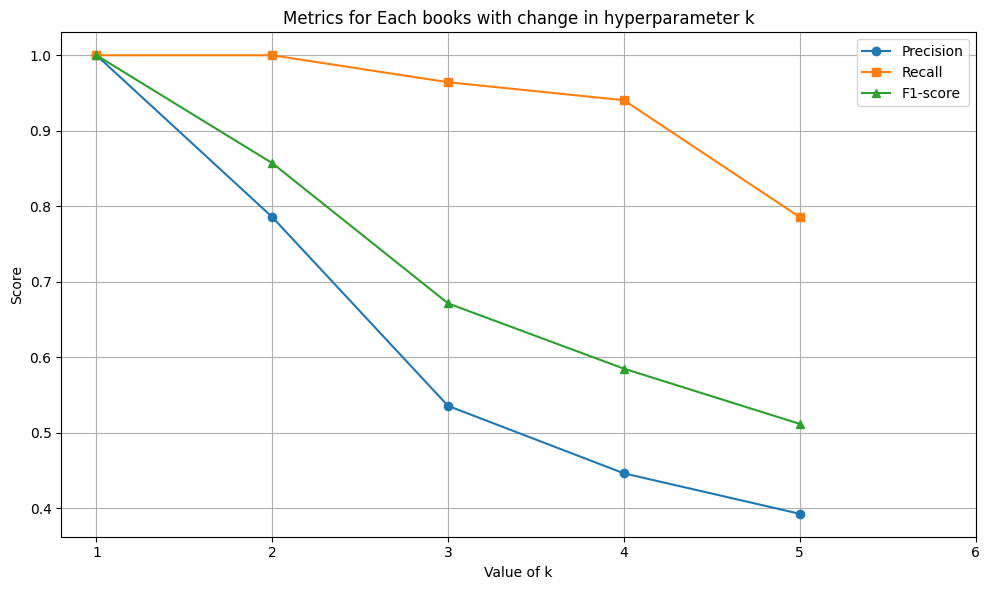

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot([x + 1 for x in range(len(precision_list_test))],precision_list_test, label='Precision', marker='o')
plt.plot([x + 1 for x in range(len(recall_list_test))],recall_list_test, label='Recall', marker='s')
plt.plot([x + 1 for x in range(len(f1_score_list_test))],f1_score_list_test, label='F1-score', marker='^')

plt.title('Metrics for Each books with change in hyperparameter k')
plt.xlabel('Value of k')
plt.ylabel('Score')
plt.xticks(range(1, len(df_actual_books)))
plt.legend()
plt.grid(True)
plt.tight_layout()

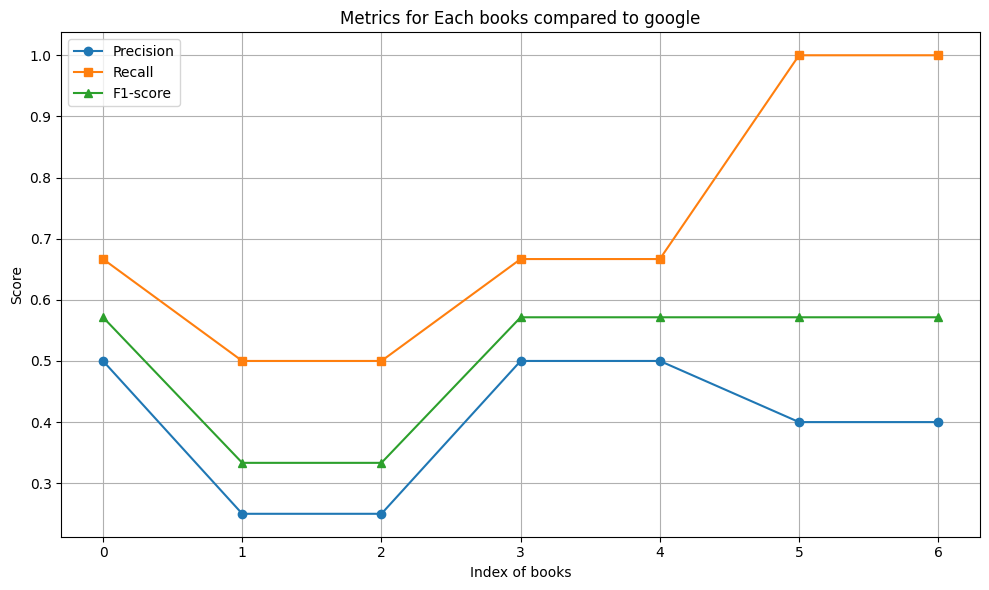

Precision: 0.39999999999999997
Recall: 0.7142857142857143
F1-score: 0.5034013605442178


In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(precision_list_google, label='Precision', marker='o')
plt.plot(recall_list_google, label='Recall', marker='s')
plt.plot(f1_score_list_google, label='F1-score', marker='^')

plt.title('Metrics for Each books compared to google')
plt.xlabel('Index of books')
plt.ylabel('Score')
plt.xticks(range(len(df_actual_books)))
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
print("Precision:", precision_google/len(df_actual_books))
print("Recall:", recall_google/len(df_actual_books))
print("F1-score:", f1_score_google/len(df_actual_books))

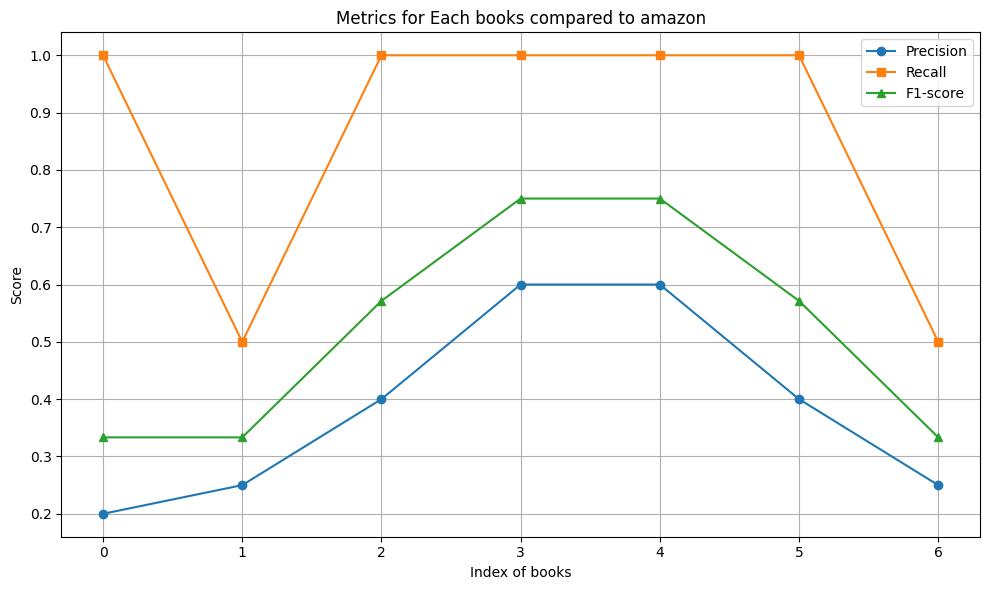

Precision: 0.38571428571428573
Recall: 0.8571428571428571
F1-score: 0.5204081632653061


In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(precision_list_amazon, label='Precision', marker='o')
plt.plot(recall_list_amazon, label='Recall', marker='s')
plt.plot(f1_score_list_amazon, label='F1-score', marker='^')

plt.title('Metrics for Each books compared to amazon')
plt.xlabel('Index of books')
plt.ylabel('Score')
plt.xticks(range(len(df_actual_books)))
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
print("Precision:", precision_amazon/len(df_actual_books))
print("Recall:", recall_amazon/len(df_actual_books))
print("F1-score:", f1_score_amazon/len(df_actual_books))

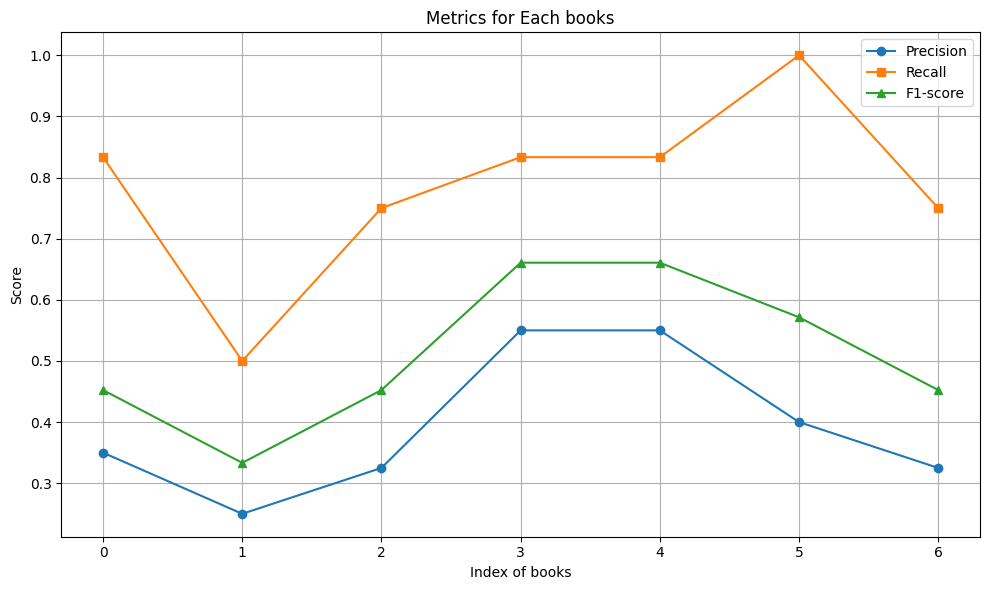

Precision: 0.3928571428571429
Recall: 0.7857142857142856
F1-score: 0.511904761904762


In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(precision_list, label='Precision', marker='o')
plt.plot(recall_list, label='Recall', marker='s')
plt.plot(f1_score_list, label='F1-score', marker='^')

plt.title('Metrics for Each books')
plt.xlabel('Index of books')
plt.ylabel('Score')
plt.xticks(range(len(df_actual_books)))
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
print("Precision:", precision/len(df_actual_books))
print("Recall:", recall/len(df_actual_books))
print("F1-score:", f1_score/len(df_actual_books))